# Введение в искусственные нейронные сети
# Урок 5. Сверточные нейронные сети

In [15]:
# pip install --user kaggle

In [16]:
# bash
# kaggle competitions download -c dogs-vs-cats

In [ ]:
# Используем ноутбук одного из участников Kaggle-соревнования dogs-vs-cats
# https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

# Но модель реализуем по аналогии с нейросетью Alexnet

In [20]:
# Import Library

In [60]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../input"))

['.DS_Store', 'test1', 'test1.zip', 'train']


In [61]:
# Define Constants

In [62]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [63]:
# Prepare Traning Data

In [64]:
filenames = os.listdir("../input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [65]:
df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


In [66]:
df.tail()

,filename,category
24995,dog.8008.jpg,1
24996,dog.1992.jpg,1
24997,dog.12412.jpg,1
24998,cat.2701.jpg,0
24999,cat.10148.jpg,0


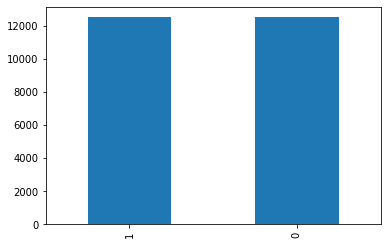

In [67]:
df['category'].value_counts().plot.bar()

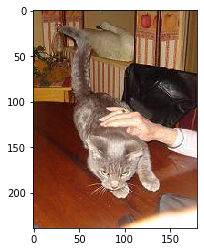

In [68]:
sample = random.choice(filenames)
image = load_img("../input/train/"+sample)
plt.imshow(image)

# Build Model
<img src="https://neurohive.io/wp-content/uploads/2018/10/AlexNet-1-1.png" width="100%"/>

## Input Layer: It represent input image data. 
It will reshape image into single diminsion array. 
Example your image is 64x64 = 4096, it will convert to (4096,1) array.

Conv Layer: This layer will extract features from image.

Pooling Layer: This layerreduce the spatial volume of input image after convolution.

Fully Connected Layer: It connect the network from a layer to another layer

Output Layer: It is the predicted values layer.

In [117]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

# первый сверточный слой
model.add(Conv2D(96, (11,11), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
# второй пуллинговый слой
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# третий сверточный слой
model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(BatchNormalization())
# четвертый пуллинговый слой
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# пятый полносвязный слой
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3, 3)))
# model.add(Dropout(0.25))

# шестой сверточный слой
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(BatchNormalization())
# седьмой пуллинговый слой
model.add(MaxPooling2D(pool_size=(3,3)))

# сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
model.add(Flatten())

# восьмой полносвязный слой
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())

# деаятый полносвязный слой
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# выходной слой с функцией активации softmax
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_147 (Conv2D)          (None, 118, 118, 96)      34944     
_________________________________________________________________
batch_normalization_135 (Bat (None, 118, 118, 96)      384       
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 59, 59, 96)        0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 59, 59, 96)        0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 55, 55, 256)       614656    
_________________________________________________________________
batch_normalization_136 (Bat (None, 55, 55, 256)       1024      
_________________________________________________________________
max_pooling2d_122 (MaxPoolin (None, 18, 18, 256)     

In [70]:
# Callbacks

In [118]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [119]:
# **Early Stop**
# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [120]:
earlystop = EarlyStopping(patience=10)

In [121]:
# **Learning Rate Reduction**
# We will reduce the learning rate when then accuracy not increase for 2 steps

In [122]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [123]:
callbacks = [earlystop, learning_rate_reduction]

In [124]:
# Prepare data

In [125]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [126]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

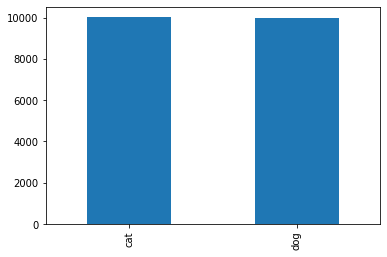

In [127]:
train_df['category'].value_counts().plot.bar()

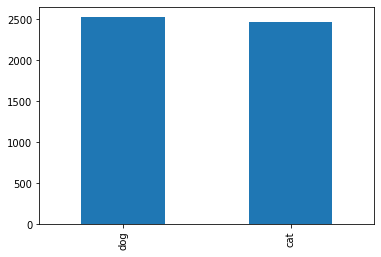

In [128]:
validate_df['category'].value_counts().plot.bar()

In [129]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [130]:
# Traning Generator

In [131]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [132]:
### Validation Generator

In [133]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [134]:
# See how our generator work

In [135]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


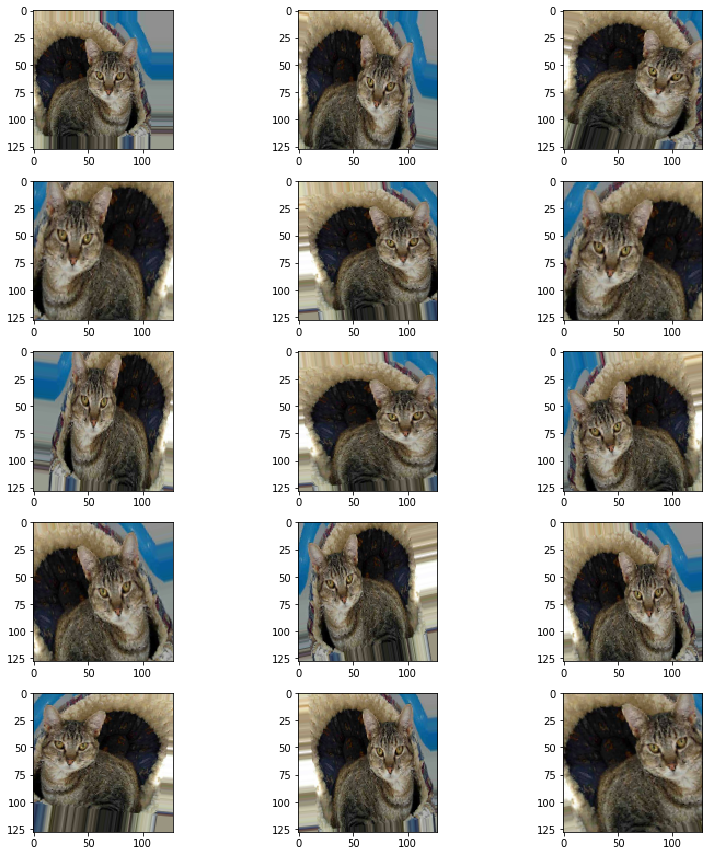

In [136]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [137]:
# Fit Model

In [ ]:
# Для обучения зададим всего 2 эпохи, т.к. расчет очень громоздкий при запуске без GPU

In [138]:
epochs=2 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/2
1333/1333 [==============================] - 4409s 3s/step - loss: 0.7936 - accuracy: 0.5634 - val_loss: 0.4237 - val_accuracy: 0.6034
Epoch 2/2


/Users/radik/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1333/1333 [==============================] - 4291s 3s/step - loss: 0.6355 - accuracy: 0.6550 - val_loss: 0.7445 - val_accuracy: 0.6602


In [ ]:
# accuracy: 0.6602 - пока нечем гордиться

In [ ]:
# Сохраним полученную модель

In [139]:
model.save_weights("model.h5")

In [ ]:
# Virtualize Training

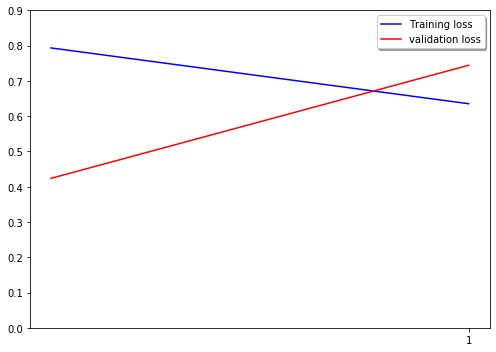

In [164]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

# ax2.plot(history.history['acc'], color='b', label="Training accuracy")
# ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
# ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
1. # Prepare Testing Data

In [144]:
test_filenames = os.listdir("../input/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [145]:
# Create Testing Generator

In [146]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [147]:
# Predict

In [148]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [149]:
# For categoral classication the prediction will come with probability of each category. 
# So we will pick the category that have the highest probability with numpy average max

In [150]:
test_df['category'] = np.argmax(predict, axis=-1)

In [151]:
# We will convert the predict category back into our generator classes by using train_generator.class_indices. 
# It is the classes that image generator map while converting data into computer vision

In [152]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [153]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [154]:
### Virtaulize Result

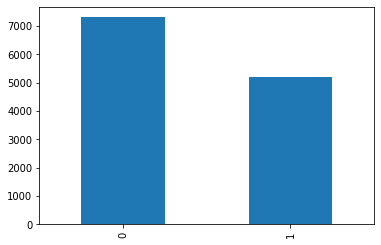

In [155]:
test_df['category'].value_counts().plot.bar()

In [156]:
 ### See predicted result with images

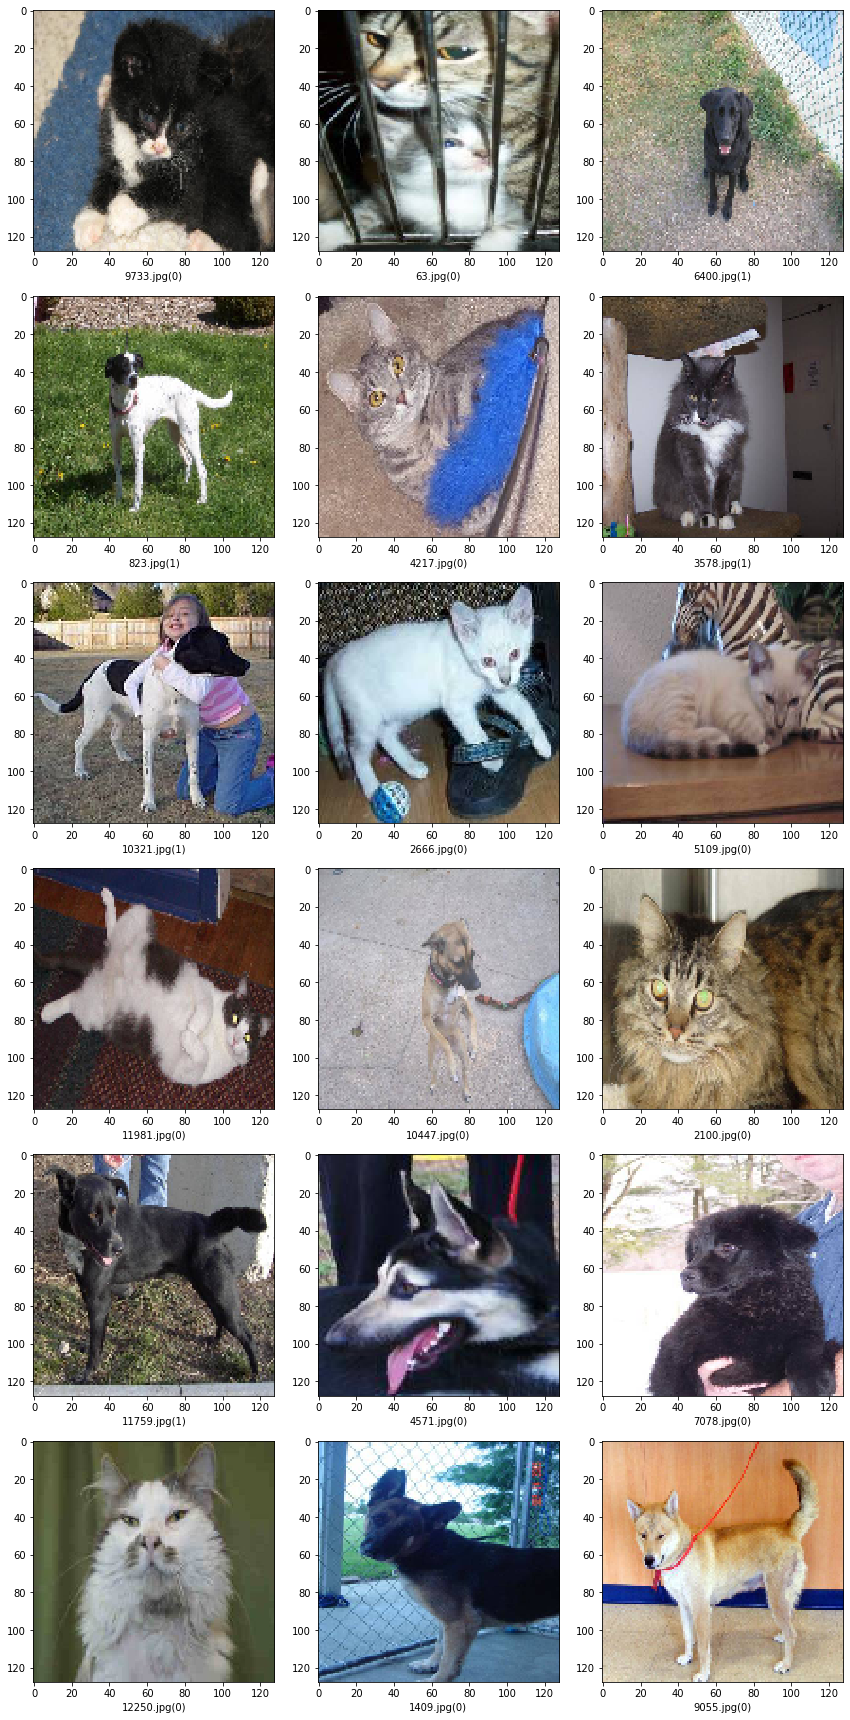

In [158]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [165]:
# Из результатов предсказания, видно что модель не дообученная: большинство картинок отнесено к категории "коты", верно 12/18

In [159]:
# Сохраним результаты предсказания в файл

In [160]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)